In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import sys
import time
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from keras_tuner import BayesianOptimization
import keras

import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune_T as chase_xgb_tune
import AC_Import_AE_Tune as chase_ae_tune

2024-02-22 12:21:49.739426: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-22 12:21:49.739470: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-22 12:21:49.739500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-22 12:21:49.747493: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-22 12:21:50.984064: W tensorflow/compiler/tf2t

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder
### LCCDATA files saved in lccdata_folder

In [2]:
# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'
prmtop_2 = 'myc_091-160_D132-P_stripped.prmtop'
nc_2 = 'aMD_091-160_D132-P_no1-4_stripped.nc'
protein_length = 70
window_range = range(2, 52)

# Setup folders and execute scripts
cpptraj_folder, lccdata_folder, should_proceed = chase_lcc.setup_folders()
if should_proceed:
    chase_lcc.execute_cpptraj_scripts(prmtop_1, nc_1, prmtop_2, nc_2, protein_length, window_range, cpptraj_folder, lccdata_folder)
else:
    print("No need to regenerate cpptraj scripts or lccdata files.")

In [3]:
# Create LCCDATA files
chase_lcc.execute_cpptraj_commands(cpptraj_folder, window_range)

cpptraj files already generated.


Generating LCCData files: 100%|███████████████| 100/100 [03:22<00:00,  2.03s/it]

LCCData files generated.


# Load LCCDATA and attach to variables wt_dict[window] and D132P_dict[window]

In [4]:
lccdata_folder = 'lccdata_files'

# Import LCC data files for wild type protein and mutant protein
wt_dict = chase_lcc.import_lcc_data(lccdata_folder, 'w')
D132P_dict = chase_lcc.import_lcc_data(lccdata_folder, 'm')

# Create Local Compaction Plots

In [5]:
save_folder = 'Local_Compaction_Plot_Figures'
if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
    for window in window_range:
        chase_lcc.LCC_plot_individual(window, wt_dict[window], D132P_dict[window], save_folder)
else:
    print("Local compaction plots already generated and saved in 'Local_Compaction_Plot_Figures'")

# Feature Engineering:

#### XGBoost Hyperparameter Evaluation
- Pre-prepares data
- Runs XGBoost on each window size with default hyperparameters
- Performs XGBoost hyperparameter tuning
- Generates figures to compare the performance of hyperparameters

In [6]:
trainer = chase_xgb_tune.XGBoostTrainer(
    wt_dict=wt_dict,
    D132P_dict=D132P_dict,
    window_sizes=range(2, 52),
    default_hyperparameters={'use_label_encoder': False, 'eval_metric': 'logloss'},
    eta_values=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    max_depth_values=[6, 9, 12, 15, 18, 21, 24],
    subsample_values=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
)

In [7]:
# This cell takes ~39 minutes to tune and run if the trial number does not exist
try:
    trainer.load_tuning_results(1)  # Loads trial information if trial # exists
except FileNotFoundError as e:
    print(e)
    print("Running new tuning session instead.")
    trainer.tune_hyperparameters_and_save()

# Evaluate default hyperparameters after either loading or tuning
trainer.evaluate_default_hyperparameters()

No tuning results found for trial number 1
Running new tuning session instead.
Tuning results saved in XGB_Tuning/XGB_Tuning_Trial_1


Possible values for Eta: [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


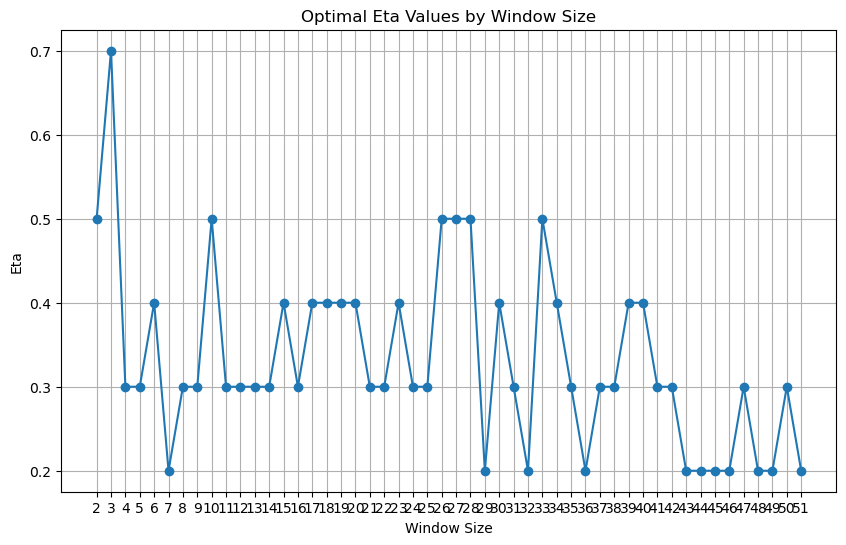

Possible values for Max Depth: [6, 9, 12, 15, 18, 21, 24]


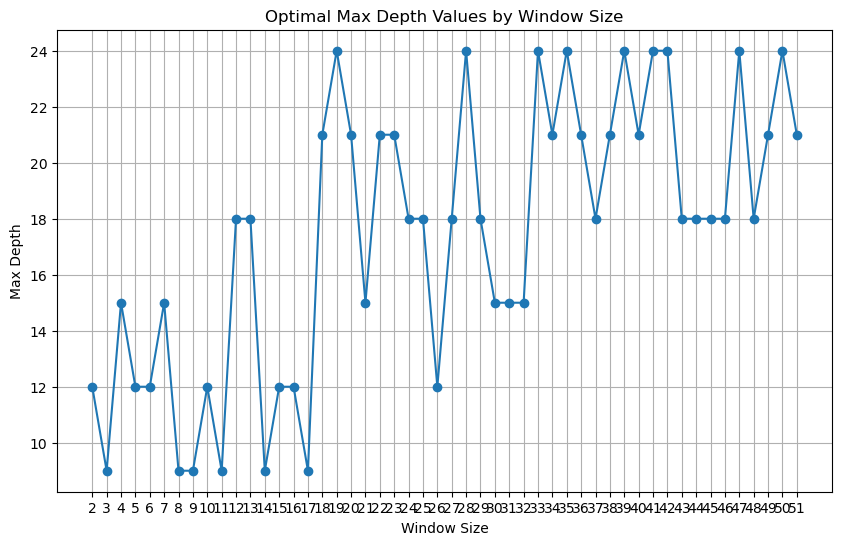

Possible values for Subsample: [0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]


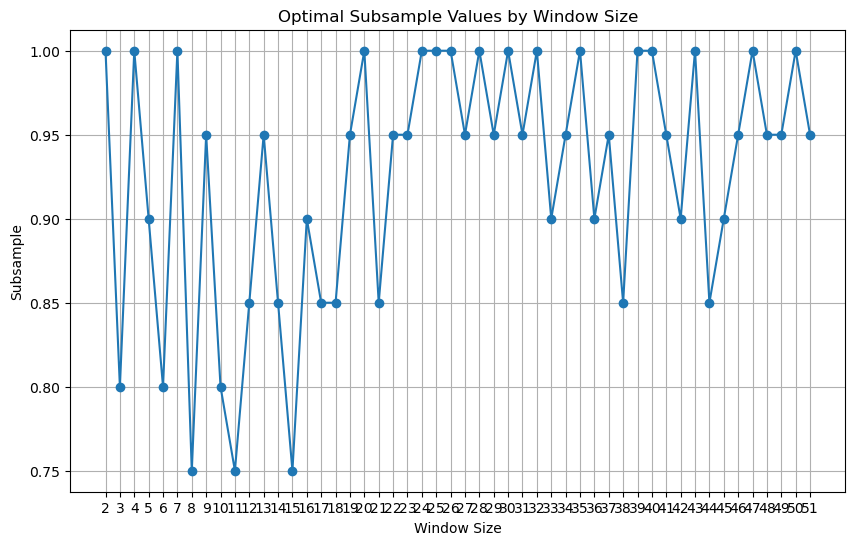

Error: No valid accuracy data available for plotting.
Average accuracy with default hyperparameters: 0.9276
Average accuracy with tuned hyperparameters: 0.9283


<Figure size 1000x600 with 0 Axes>

In [8]:
# Plot best hyperparameter values for each window size
trainer.plot_specific_hyperparameter_values(trainer.best_eta_values, 'Optimal Eta Values by Window Size', 'Eta', trainer.eta_values)
trainer.plot_specific_hyperparameter_values(trainer.best_max_depth_values, 'Optimal Max Depth Values by Window Size', 'Max Depth', trainer.max_depth_values)
trainer.plot_specific_hyperparameter_values(trainer.best_subsample_values, 'Optimal Subsample Values by Window Size', 'Subsample', trainer.subsample_values)

# The overall best accuracy by window size plot can be achieved with the existing method
trainer.plot_hyperparameter_values(trainer.window_sizes, trainer.default_accuracy_values, trainer.best_accuracy_values, 'Accuracy Comparison: Default vs. Tuned Hyperparameters')

# Calculate and display average accuracies
average_default_accuracy = np.mean(list(trainer.default_accuracy_values.values()))
average_tuned_accuracy = np.mean(list(trainer.best_accuracy_values.values()))
print(f"Average accuracy with default hyperparameters: {average_default_accuracy:.4f}")
print(f"Average accuracy with tuned hyperparameters: {average_tuned_accuracy:.4f}")

### Extracting Feature Importances

In [9]:
# Specify which hyperparameters to use based on above
manual_hyperparameters = {
    'n_estimators': 100,
    'max_depth': 15,
    'min_child_weight': 1,
    'subsample': 0.9,
    'eta': 0.3,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

# Specify the base feature importance threshold
# If comparing importance thresholds, set this value high to avoid saving positions
# If importance threshold already determined, skip the next 3 cells
importance_threshold = 0.2

# Save important features with adjusted thresholds for each window size
trainer.save_important_features_and_plot(importance_threshold, manual_hyperparameters)

Total positions saved: 0


### Position importance for each window size

In [ ]:
# Display the saved feature importance plots in the notebook
trainer.display_feature_importance_plots('XGB_Pos_Imp_Figs')

## Compare Positions Saved For Different Thresholds: 

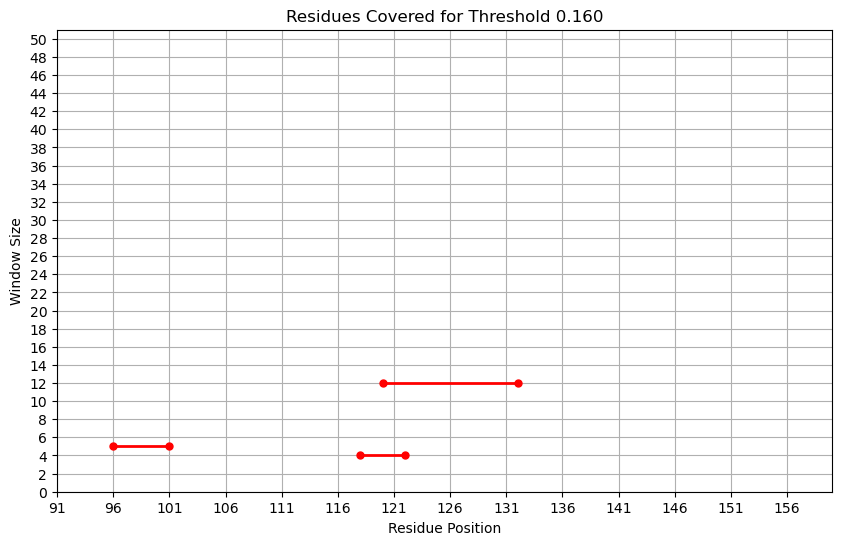

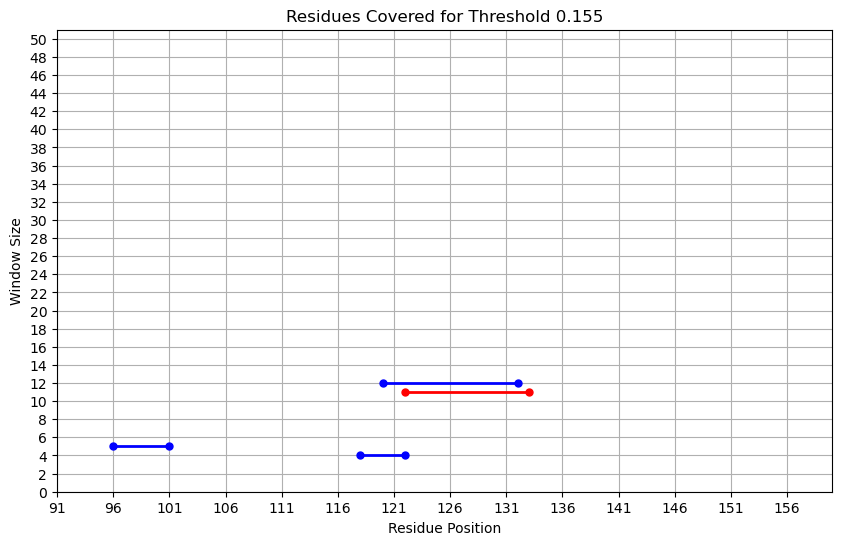

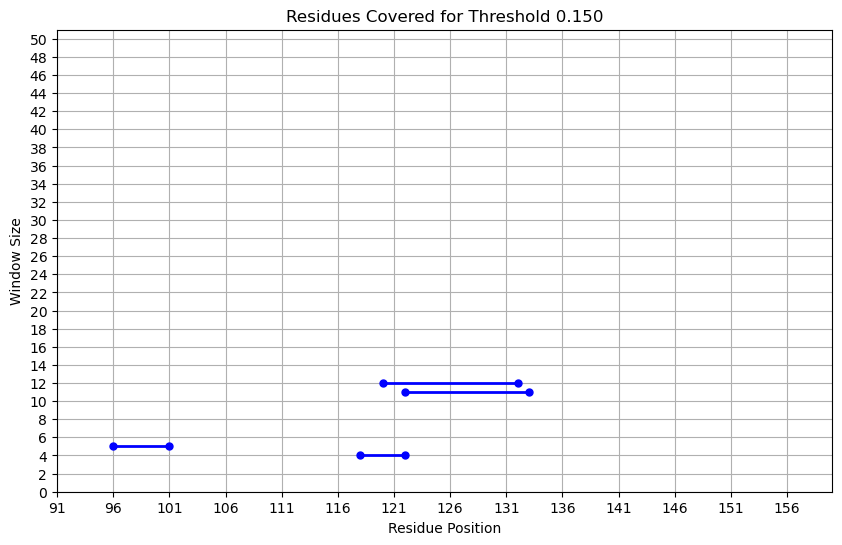

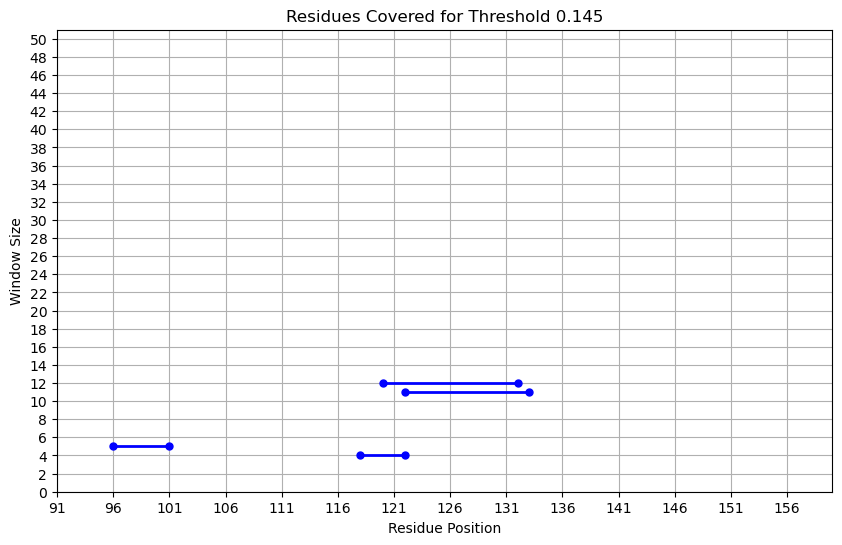

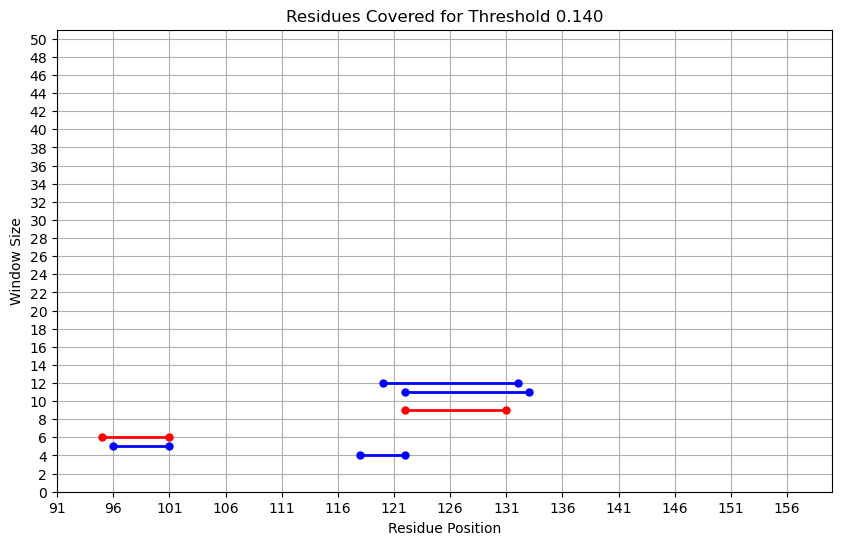

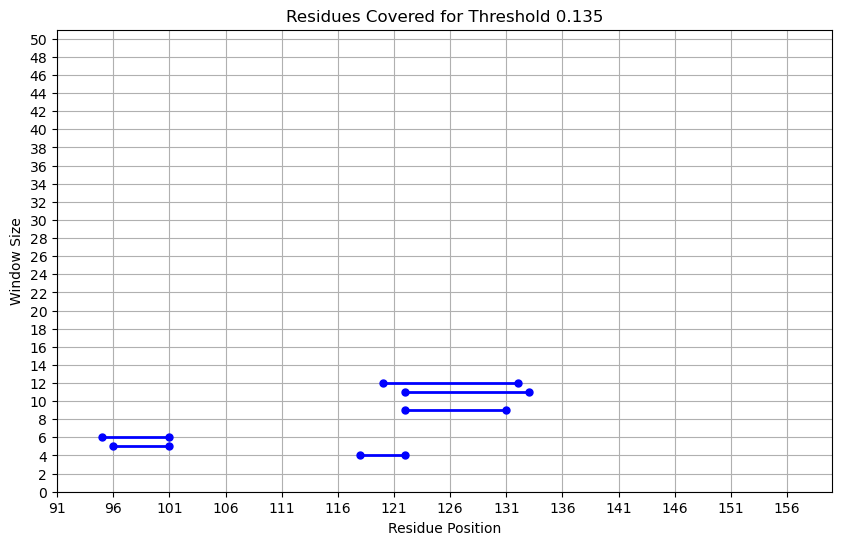

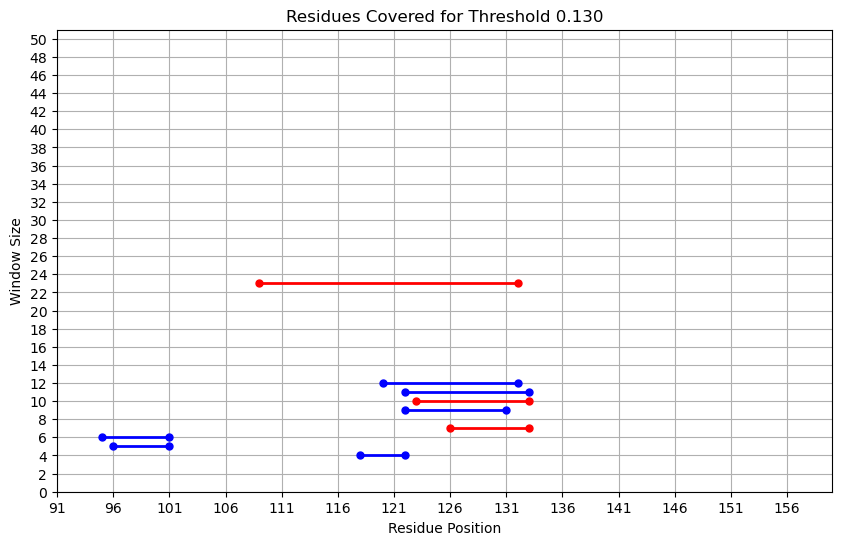

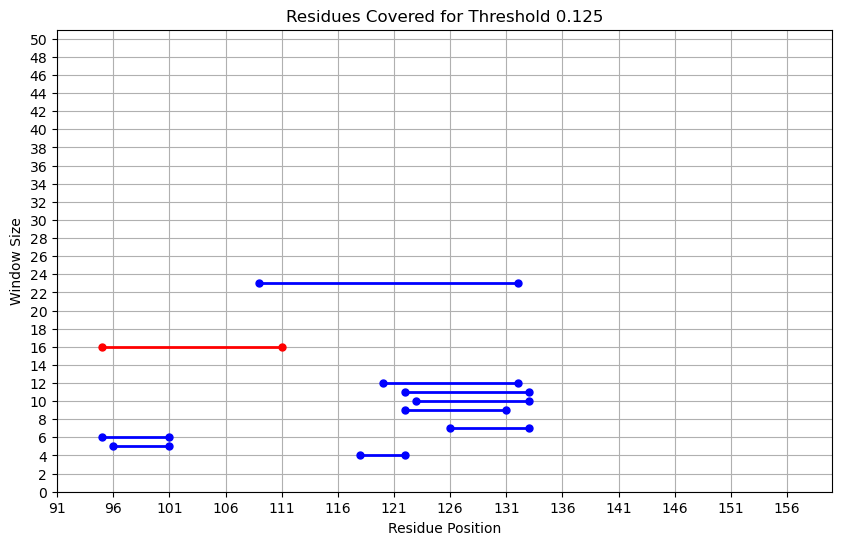

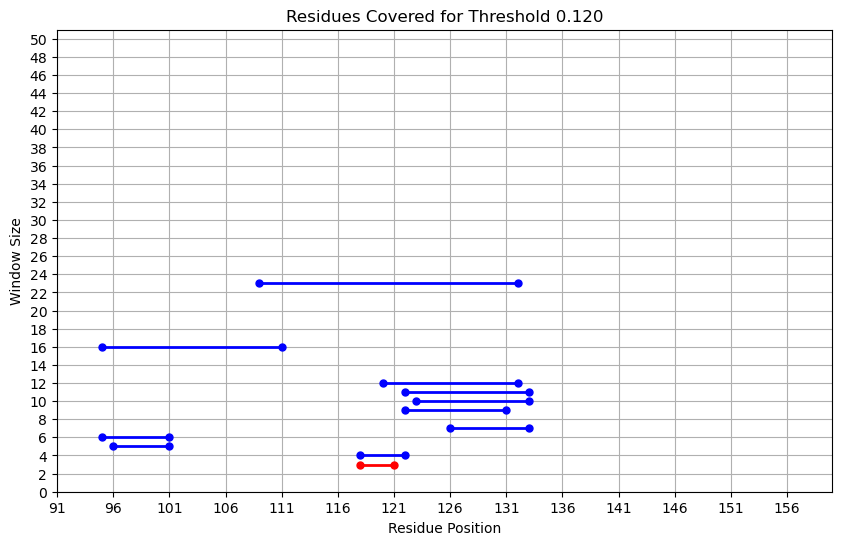

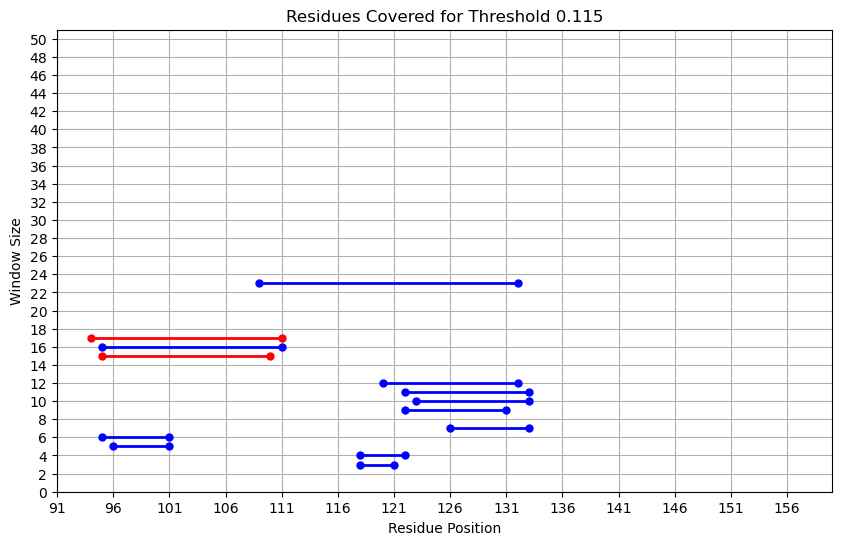

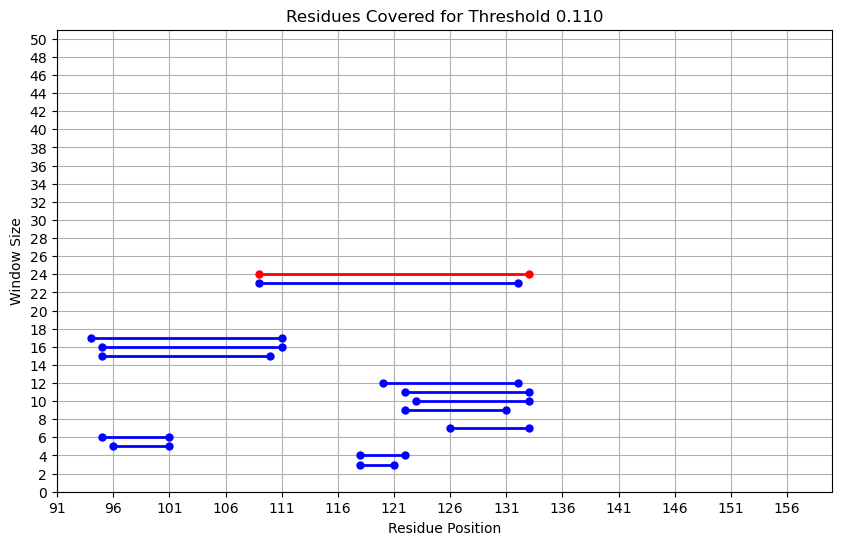

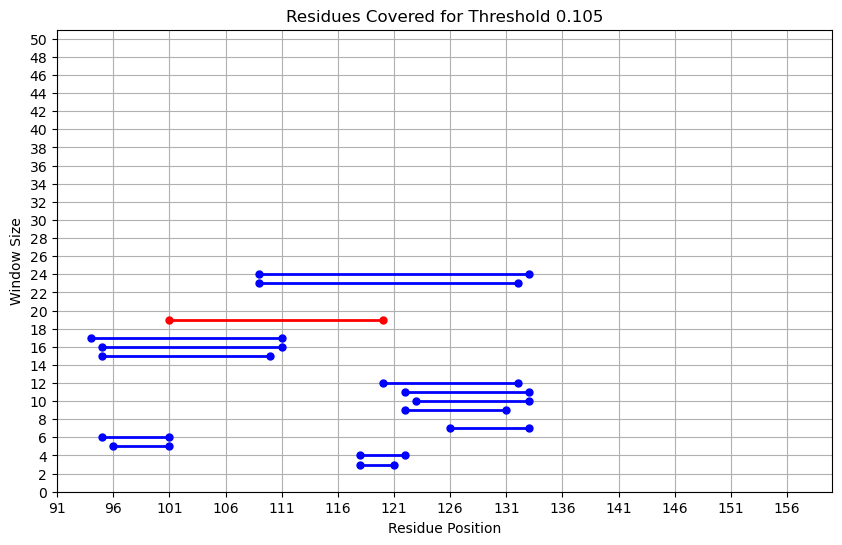

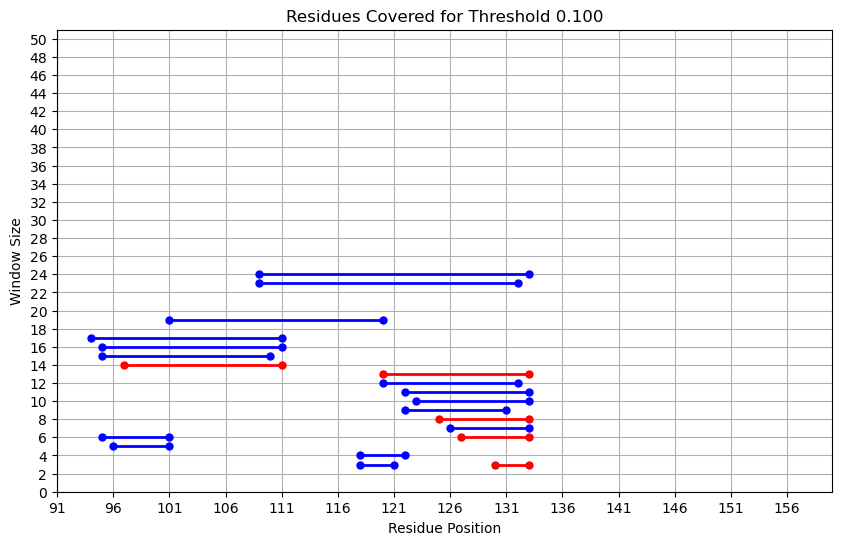

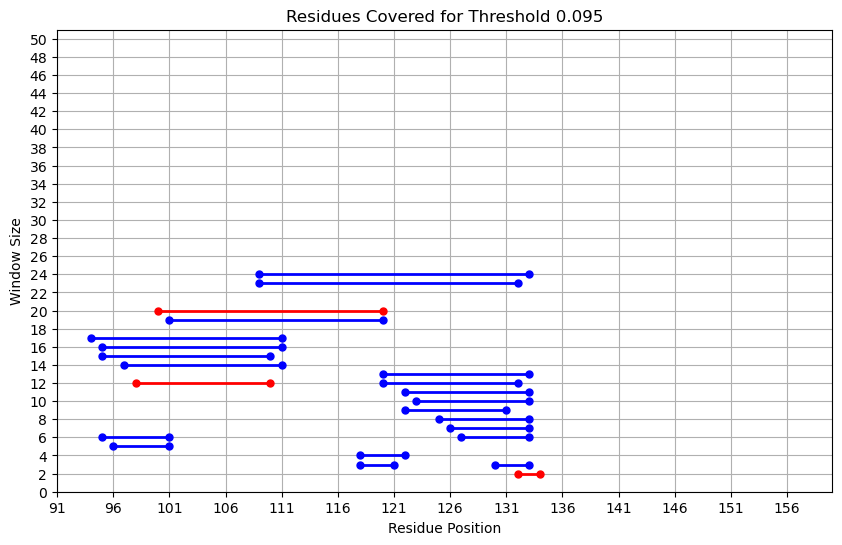

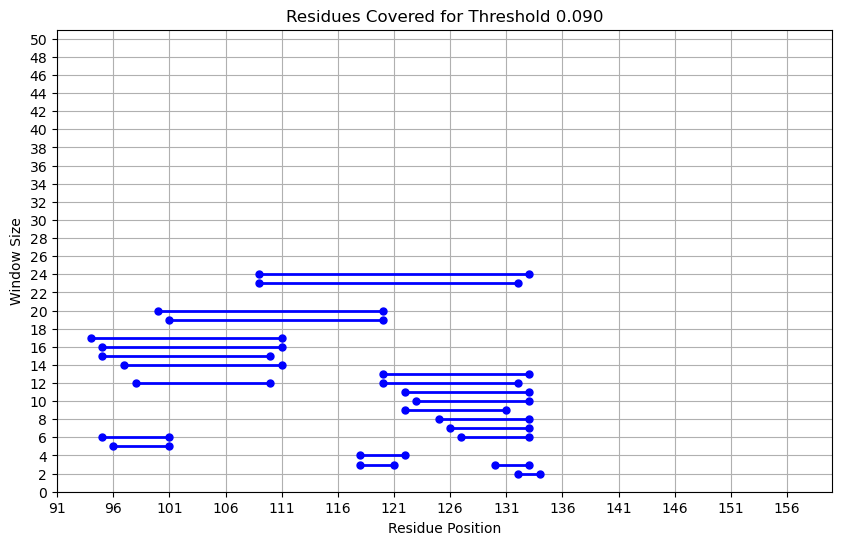

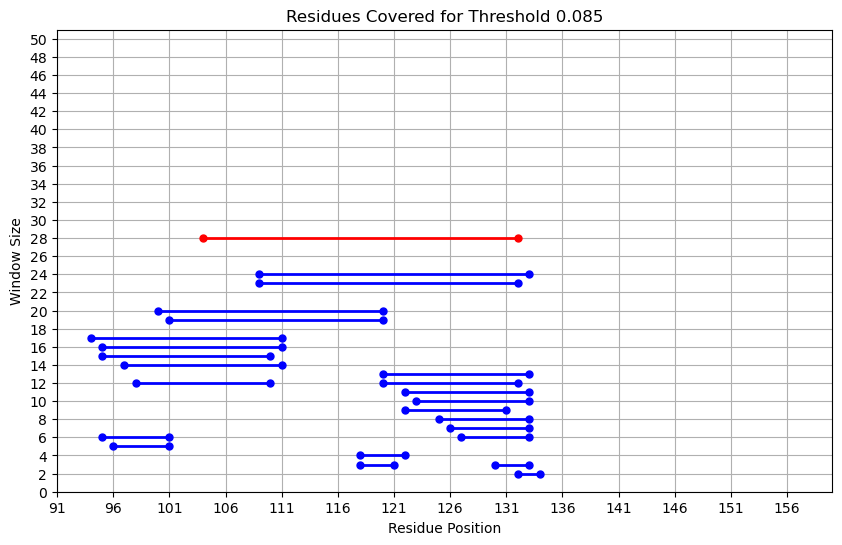

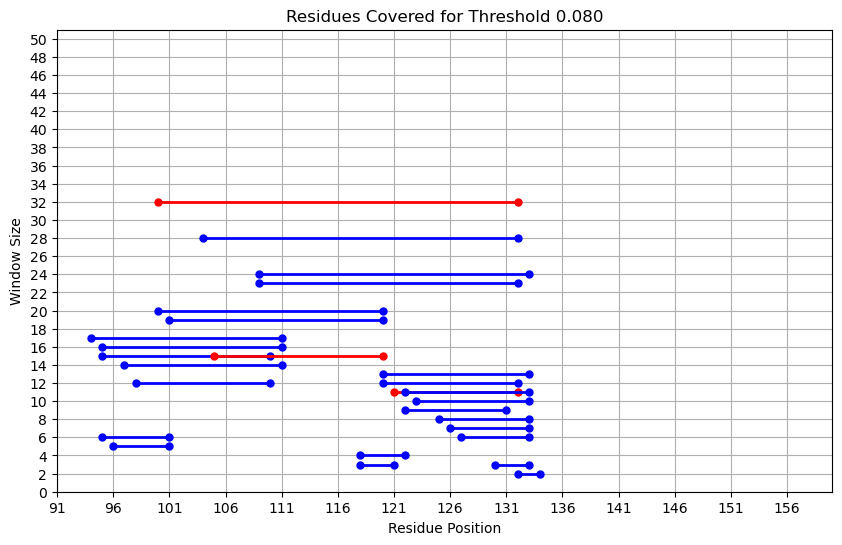

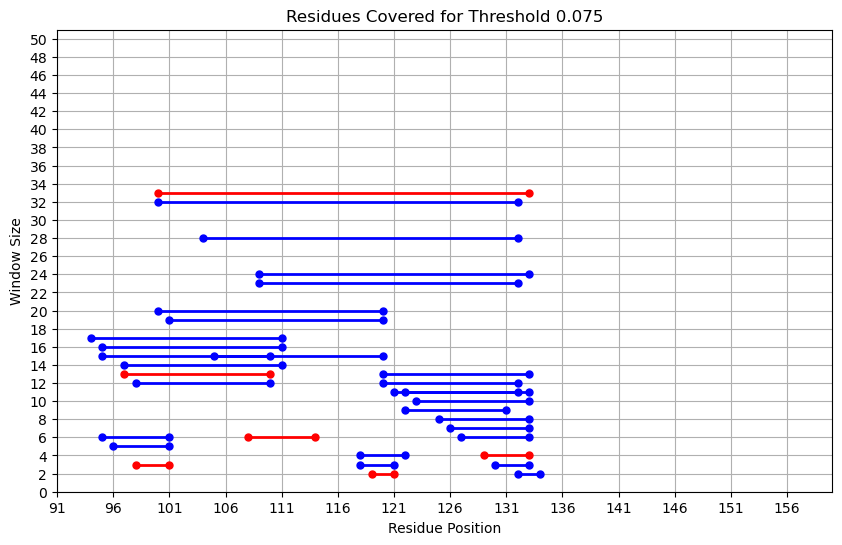

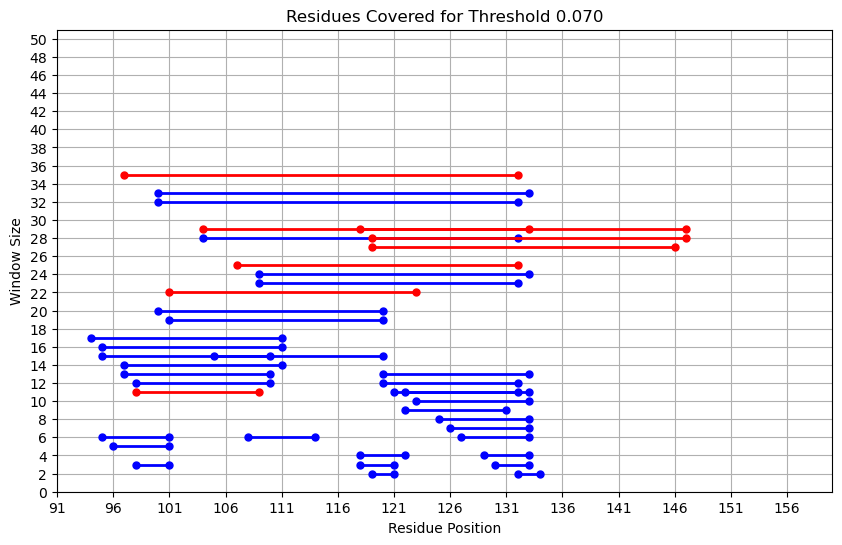

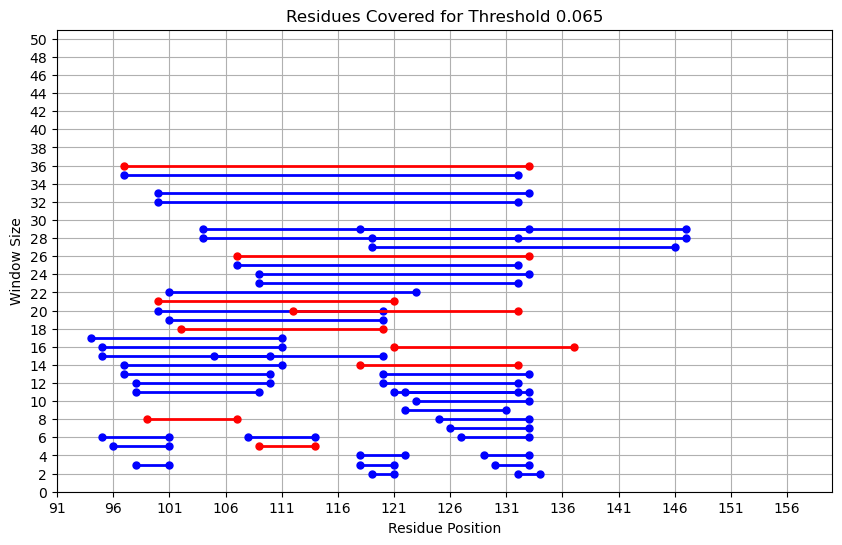

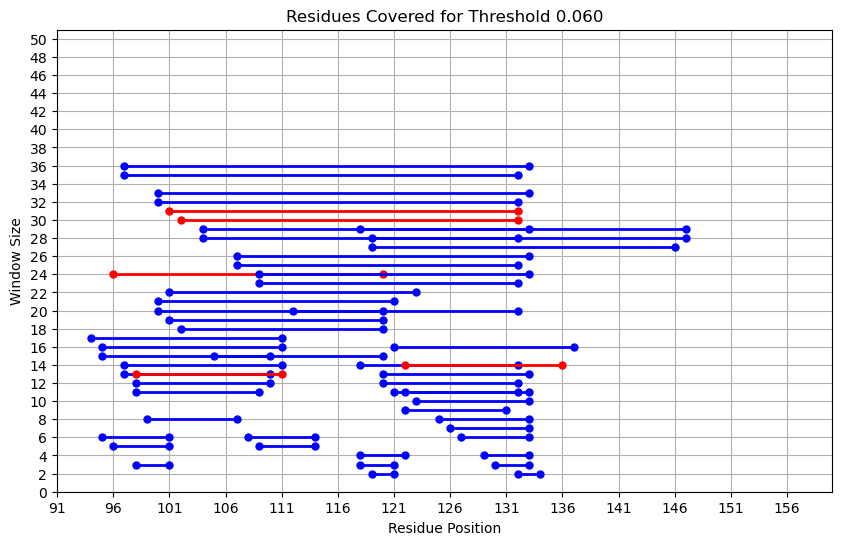

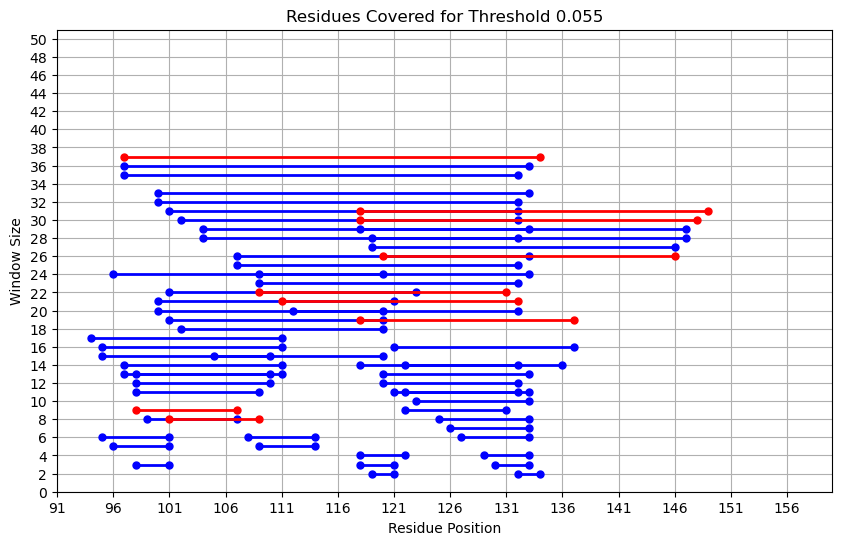

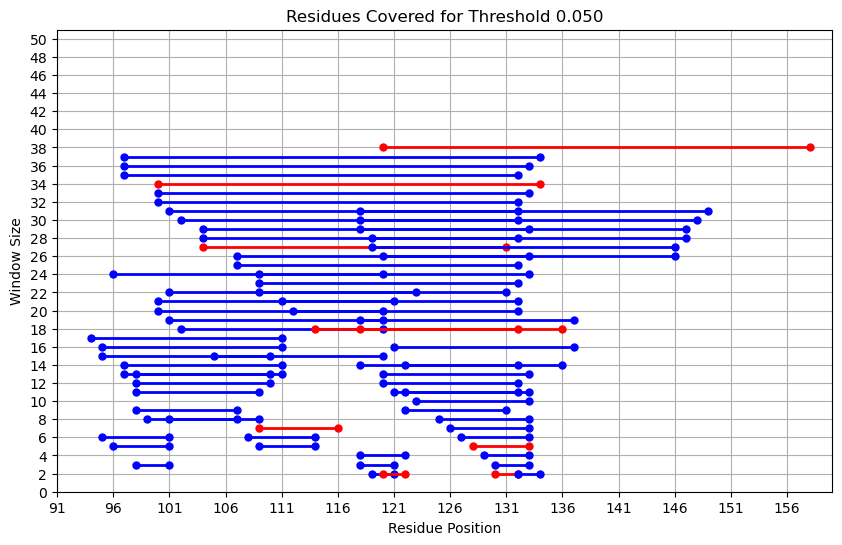

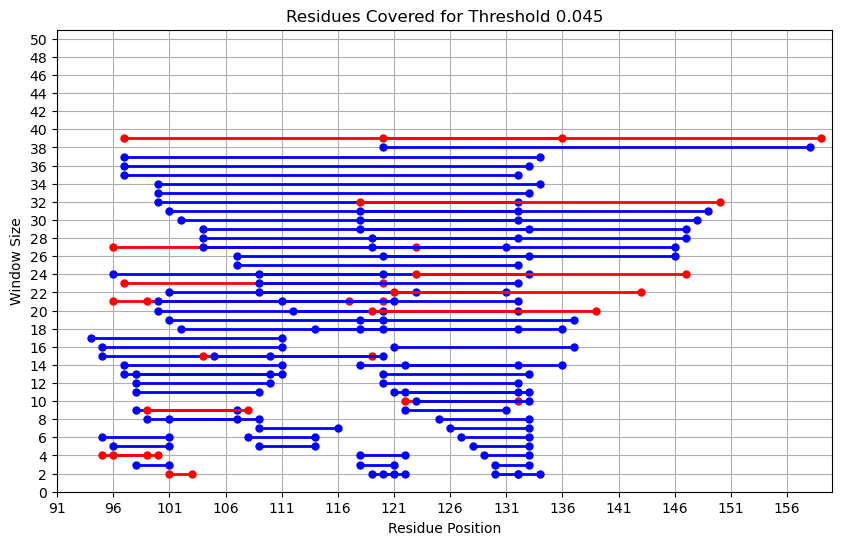

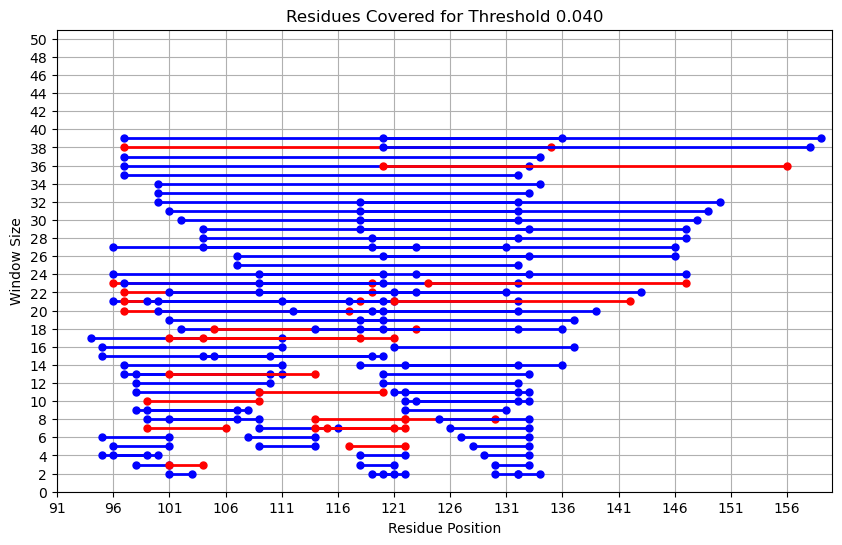

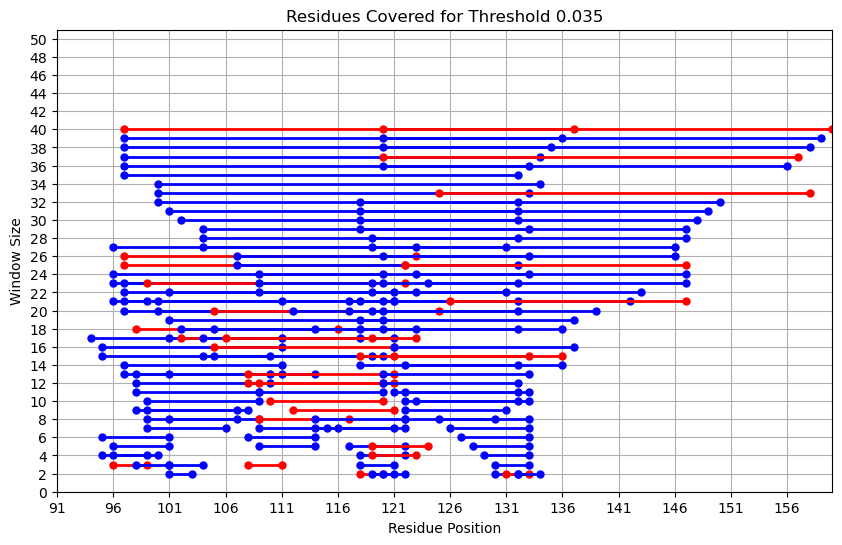

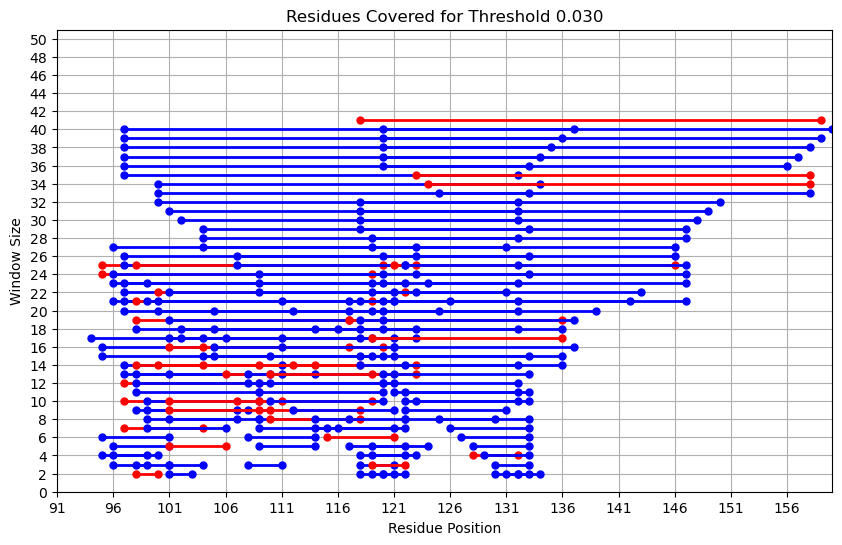

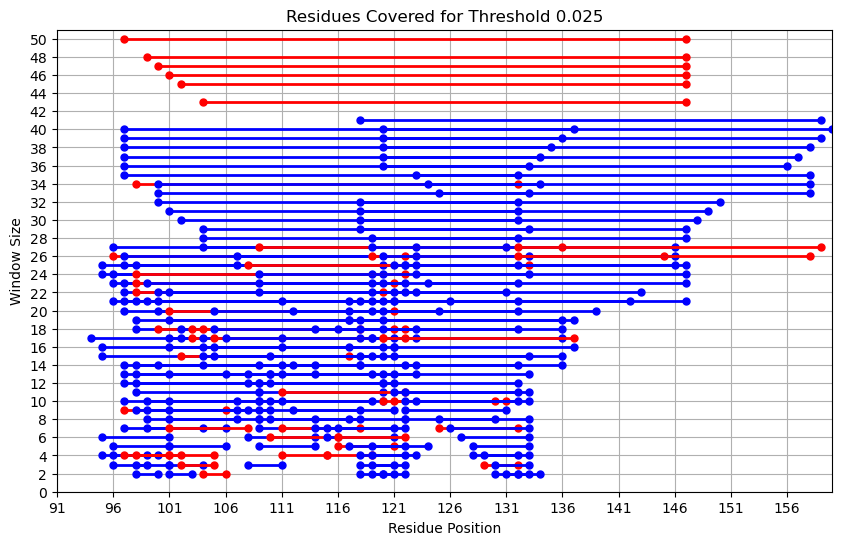

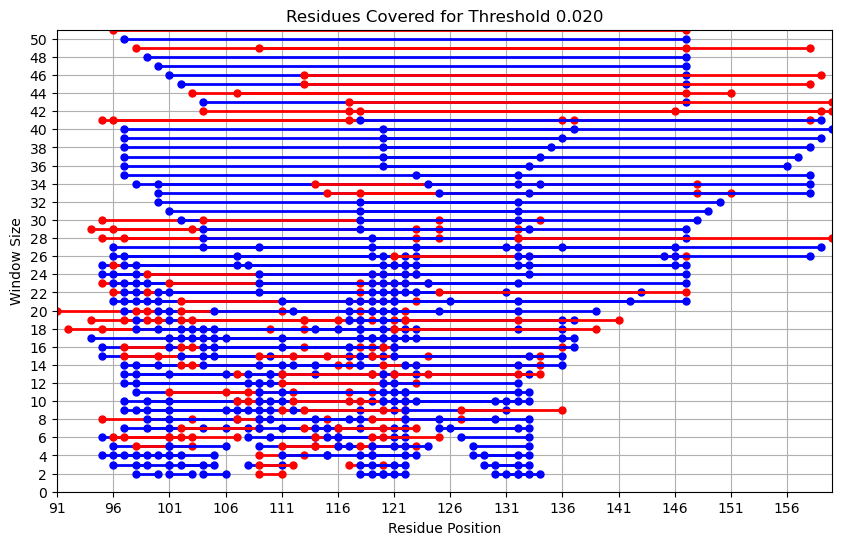

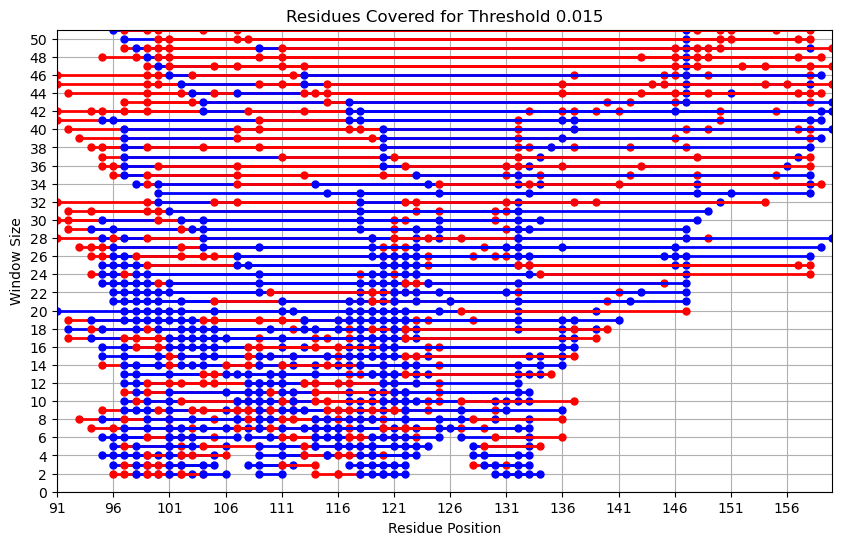

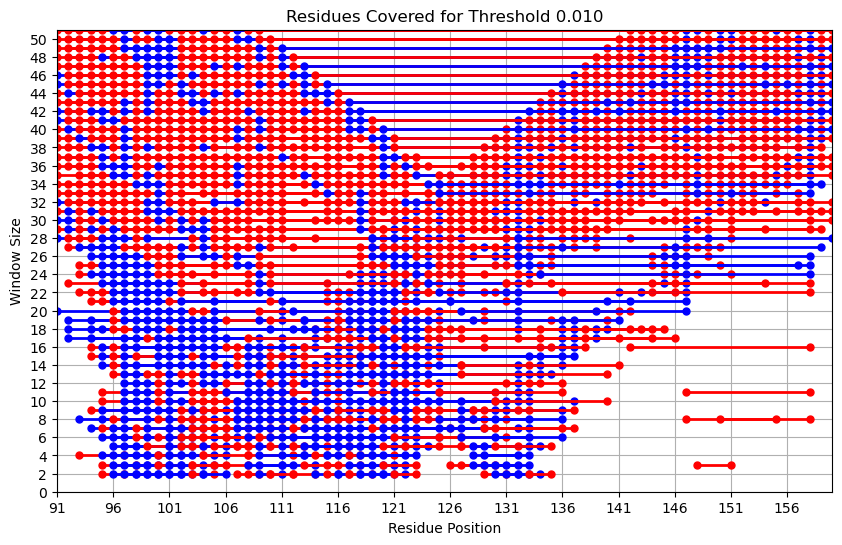

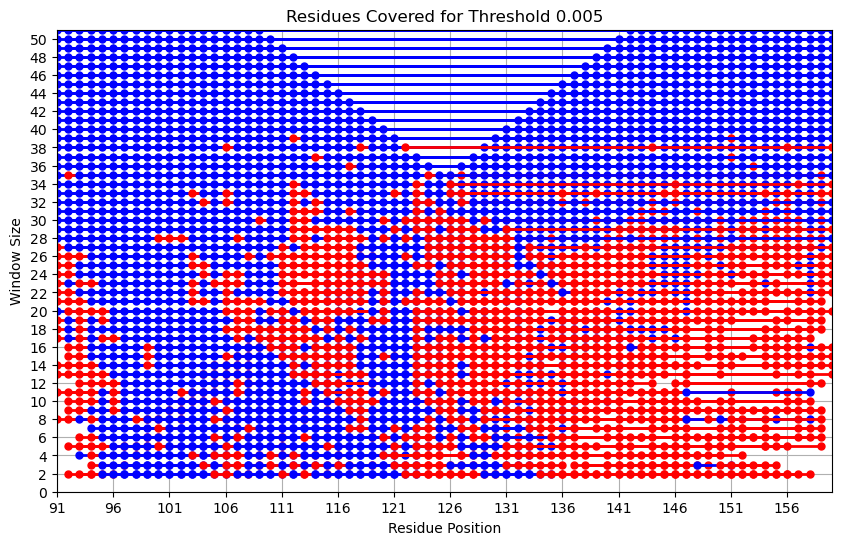

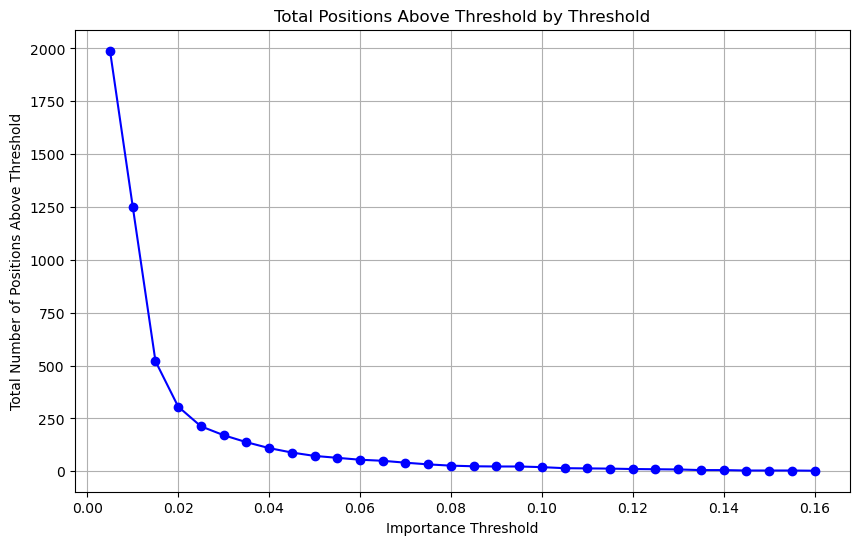

In [10]:
# Cell to calculate and plot positions for different importance_thresholds
importance_thresholds = np.arange(0.16, 0.004, -0.005)
trainer.calculate_and_plot_positions(importance_thresholds)

## Save Positions Above Specified Threshold

In [ ]:
specified_threshold = 0.03
trainer.save_positions_above_threshold(specified_threshold)

## Data Import and Preparation

In [ ]:
# Load and concatenate dataframes
wt_f = chase_ae_tune.load_and_concatenate('wt', 'wt')
D132P_f = chase_ae_tune.load_and_concatenate('D132P', 'D132P')

In [ ]:
# Preprocessing
X_train_f, X_valid_f, y_train_f, y_valid_f = chase_ae_tune.preprocessing(wt_f, D132P_f)

# Tuning 

### Tuning Number of Nodes & Layers

In [ ]:
# This takes approximately 13 hours to run
# Prepare Keras Tuner with Bayesian Optimization
tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder(hp, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    num_initial_points=20,
    directory='AE_Tuning',
    project_name='AET_Nodes_Layers'
)

# Start tuning
tuner.search(
    X_train_f, X_train_f,
    epochs=200,
    batch_size=256,
    validation_data=(X_valid_f, X_valid_f)
)

# Update Tracker
chase_ae_tune.update_best_overall(tuner, 'nodes_layers', additional_details={
    'num_layers': tuner.get_best_hyperparameters()[0].get('num_layers'),
    'nodes_per_layer': [tuner.get_best_hyperparameters()[0].get(f'nodes_{i}') for i in tuner.get_best_hyperparameters()[0].get('num_layers')]
})

In [ ]:
# Get the best model and print summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

In [ ]:
# Fetch the full details of the top 5 trials
top_trials = tuner.oracle.get_best_trials(num_trials=5)

# Print the details of the top 5 trials
for i, trial in enumerate(top_trials):
    print(f"Rank: {i+1}")
    print("Hyperparameters:")
    for hp, value in trial.hyperparameters.values.items():
        print(f"{hp}: {value}")
    
    # Include the validation loss for each model
    val_loss = trial.score
    print(f"Validation Loss: {val_loss}\n")

### Tuning Batch Size & Learning Rate

In [ ]:
# Retrieve best hyperparameters from initial tuning
best_hp = tuner.get_best_hyperparameters()[0]
best_num_layers = best_hp.get('num_layers')
best_nodes_per_layer = [best_hp.get(f'nodes_{i}') for i in range(best_num_layers)]

# Set up a new tuner instance for batch size and learning rate tuning
batch_size_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_tuning(hp, best_num_layers, best_nodes_per_layer, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    num_initial_points=20,
    directory='AE_Tuning',
    project_name='AET_LR_BS'
)

batch_size_tuner.search(
    X_train_f, X_train_f,
    validation_data=(X_valid_f, X_valid_f),
    epochs=200
)

# Update Tracker
chase_ae_tune.update_best_overall(batch_size_tuner, 'batch_size_lr', {
    'batch_size': batch_size_tuner.get_best_hyperparameters()[0].get('batch_size'),
    'learning_rate': batch_size_tuner.get_best_hyperparameters()[0].get('learning_rate')
})

### Tuning Activation Functions

In [ ]:
best_learning_rate = batch_size_tuner.get_best_hyperparameters()[0].get('learning_rate')

activation_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_activation_tuning(hp, best_num_layers, best_nodes_per_layer, best_learning_rate, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=20,  
    executions_per_trial=3,
    directory='AE_Tuning',
    project_name='AET_AF'
)

activation_tuner.search(
    X_train_f, X_train_f,  
    validation_data=(X_valid_f, X_valid_f),  
    epochs=200,  
    batch_size=batch_size_tuner.get_best_hyperparameters()[0].get('batch_size')
)

# Update Tracker
activation_functions = [activation_tuner.get_best_hyperparameters()[0].get(f'encoder_activation_{i}') for i in range(best_num_layers)]

chase_ae_tune.update_best_overall(activation_tuner, 'activation_functions', {
    'activations': activation_functions
})

### Tuning Loss Function and Optimizer

In [ ]:
best_activations = [activation_tuner.get_best_hyperparameters()[0].get(f'encoder_activation_{i}') for i in range(best_num_layers)]

final_tuner = BayesianOptimization(
    lambda hp: chase_ae_tune.build_autoencoder_for_final_tuning(hp, best_num_layers, best_nodes_per_layer, best_activations, best_learning_rate, X_train_f.shape[1:]),
    objective='val_loss',
    max_trials=100,
    executions_per_trial=3,
    directory='AE_Tuning',
    project_name='AET_LF_Opt'
)

final_tuner.search(
    X_train_f, X_train_f,
    validation_data=(X_valid_f, X_valid_f),
    epochs=200,
    batch_size=activation_tuner.get_best_hyperparameters()[0].get('batch_size')
)

# Update Tracker
chase_ae_tune.update_best_overall(final_tuner, 'loss_optimizer', {
    'loss_function': final_tuner.get_best_hyperparameters()[0].get('loss_function'),
    'optimizer': final_tuner.get_best_hyperparameters()[0].get('optimizer')
})

### Tuning Summary:

In [ ]:
# Print the best overall results
print(f"Best global validation loss: {chase_ae_tune.best_overall['val_loss']}")
print("Best Hyperparameters:")
for key, value in chase_ae_tune.best_overall['details'].get(chase_ae_tune.best_overall['step'], {}).items():
    print(f"{key}: {value}")